# Solving the Damped Oscillation Equation using PINN

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import numpy as np
import matplotlib.pyplot as plt

# Defining PINN Architecture

In [2]:
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.fc1 = nn.Linear(1, 200)  # Increased width
        self.fc2 = nn.Linear(200, 200)  # Additional hidden layer
        self.fc3 = nn.Linear(200, 200)  # Additional hidden layer
        self.fc4 = nn.Linear(200, 1)   # Output layer

        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.xavier_uniform_(self.fc2.weight)
        nn.init.xavier_uniform_(self.fc3.weight)
        nn.init.xavier_uniform_(self.fc4.weight)

    def forward(self, t):
        t = torch.tanh(self.fc1(t))
        t = torch.tanh(self.fc2(t))
        t = torch.tanh(self.fc3(t))
        x = self.fc4(t)
        return x

def physics_loss(net, t, gamma, omega0):
    t.requires_grad = True
    x = net(t)
    dx_dt = torch.autograd.grad(x, t, grad_outputs=torch.ones_like(x), create_graph=True)[0]
    d2x_dt2 = torch.autograd.grad(dx_dt, t, grad_outputs=torch.ones_like(dx_dt), create_graph=True)[0]
    residual = d2x_dt2 + 2 * gamma * dx_dt + omega0**2 * x
    return torch.mean(residual**2)

In [3]:
def initial_condition_loss(net, x0, v0):
    t0 = torch.tensor([0.0], requires_grad=True).float()
    x_pred = net(t0)
    dx_pred_dt = torch.autograd.grad(x_pred, t0, create_graph=True)[0]
    loss_ic = (x_pred - x0)**2 + (dx_pred_dt - v0)**2
    return loss_ic

In [4]:
def train_pinn(net, optimizer,scheduler, gamma, omega0, x0, v0, epochs=5000):
    for epoch in range(epochs):
        def closure():
            optimizer.zero_grad()
            t = torch.linspace(0, 10, 200).view(-1, 1).float()  # More time points
            loss_physics = physics_loss(net, t, gamma, omega0)
            loss_ic = initial_condition_loss(net, x0, v0)
            loss_total = loss_physics + 10.0 * loss_ic  # Weighted initial condition loss
            loss_total.backward()
            return loss_total

        optimizer.step(closure)  # Pass the closure function to L-BFGS
        scheduler.step()
        if epoch % 100 == 0:
            loss_total = closure()
            print(f"Epoch {epoch}, Loss: {loss_total.item()}")

## Training

In [5]:
gamma = 0.5  # Damping coefficient
omega0 = 2.0 # Natural frequency
x0 = 1.0     # Initial displacement
v0 = 0.0     # Initial velocity

In [6]:
net = PINN()
optimizer = optim.LBFGS(net.parameters(), lr=0.1)  # Lower learning rate
scheduler = StepLR(optimizer, step_size=300, gamma=0.001)  # Reduce LR by 0.1 every 300 epochs
train_pinn(net, optimizer,scheduler, gamma, omega0, x0, v0)

Epoch 0, Loss: 2.243577003479004
Epoch 100, Loss: 0.00014955917140468955
Epoch 200, Loss: 8.081105988821946e-06
Epoch 300, Loss: 8.081105988821946e-06
Epoch 400, Loss: 8.081105988821946e-06
Epoch 500, Loss: 8.081105988821946e-06
Epoch 600, Loss: 8.081105988821946e-06
Epoch 700, Loss: 8.081105988821946e-06
Epoch 800, Loss: 8.081105988821946e-06
Epoch 900, Loss: 8.081105988821946e-06
Epoch 1000, Loss: 8.081105988821946e-06
Epoch 1100, Loss: 8.081105988821946e-06
Epoch 1200, Loss: 8.081105988821946e-06
Epoch 1300, Loss: 8.081105988821946e-06
Epoch 1400, Loss: 8.081105988821946e-06
Epoch 1500, Loss: 8.081105988821946e-06
Epoch 1600, Loss: 8.081105988821946e-06
Epoch 1700, Loss: 8.081105988821946e-06
Epoch 1800, Loss: 8.081105988821946e-06
Epoch 1900, Loss: 8.081105988821946e-06
Epoch 2000, Loss: 8.081105988821946e-06
Epoch 2100, Loss: 8.081105988821946e-06
Epoch 2200, Loss: 8.081105988821946e-06
Epoch 2300, Loss: 8.081105988821946e-06
Epoch 2400, Loss: 8.081105988821946e-06
Epoch 2500, Los

## Evaluation

In [7]:
t_test = torch.linspace(0, 10, 100).view(-1, 1).float()
x_pinn = net(t_test).detach().numpy()

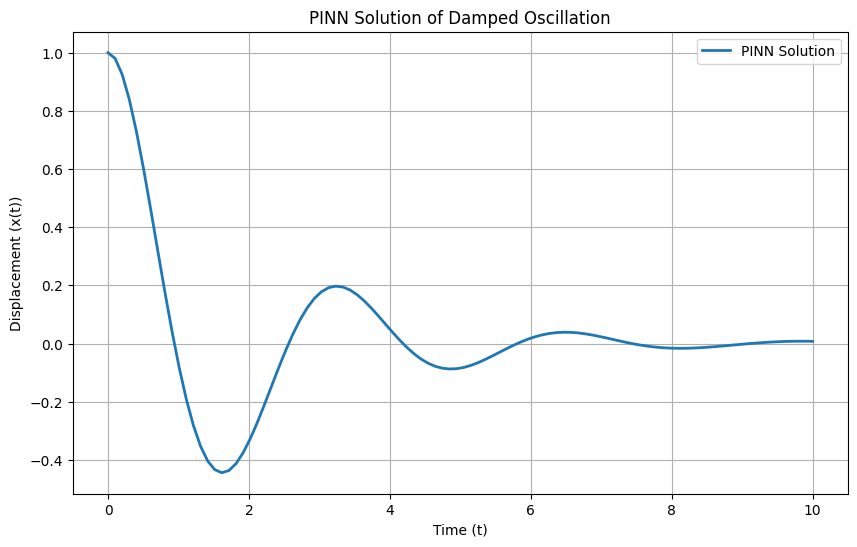

In [8]:
plt.figure(figsize=(10, 6))
plt.plot(t_test, x_pinn, label="PINN Solution", linewidth=2)
plt.xlabel("Time (t)")
plt.ylabel("Displacement (x(t))")
plt.title("PINN Solution of Damped Oscillation")
plt.legend()
plt.grid()
plt.show()

In [9]:
def analytical_solution(t):
    omega = np.sqrt(omega0**2 - gamma**2)
    A = x0
    B = (v0 + gamma * x0) / omega
    return np.exp(-gamma * t) * (A * np.cos(omega * t) + B * np.sin(omega * t))

t_analytical = np.linspace(0, 10, 100)
x_analytical = analytical_solution(t_analytical)

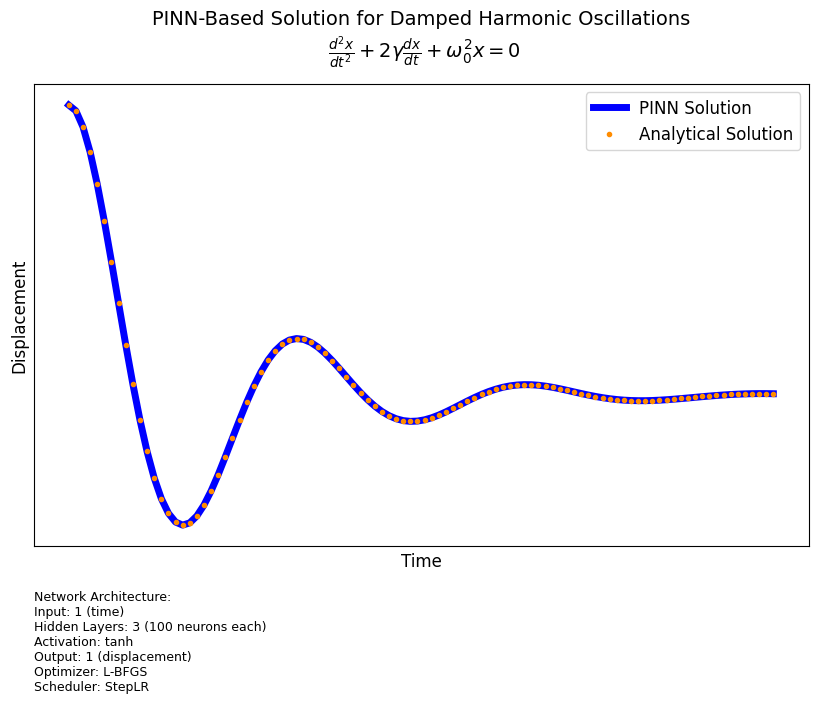

In [35]:
plt.figure(figsize=(10, 6))
plt.plot(t_test, x_pinn, label="PINN Solution", linewidth=5, color="blue")
plt.plot(t_analytical, x_analytical,marker='.',linestyle='', label="Analytical Solution", linewidth=1, color="darkorange")


plt.xticks([])
plt.yticks([])

# Add the governing equation to the title
equation = r"$\frac{d^2 x}{dt^2} + 2\gamma \frac{dx}{dt} + \omega_0^2 x = 0$"
plt.title(f"PINN-Based Solution for Damped Harmonic Oscillations\n {equation}", fontsize=14, pad=20)

# Add network architecture details below the legend
network_info = (
    "Network Architecture:\n"
    "Input: 1 (time)\n"
    "Hidden Layers: 3 (100 neurons each)\n"
    "Activation: tanh\n"
    "Output: 1 (displacement)\n"
    "Optimizer: L-BFGS\n"
    "Scheduler: StepLR\n"
)

# Add legend
legend = plt.legend(loc='upper right', fontsize=12)

# Add network architecture information below the legend
plt.text(0, -0.095, network_info, fontsize=9, color='black', 
         bbox=dict(facecolor='white', alpha=0), 
         transform=plt.gca().transAxes, verticalalignment='top', horizontalalignment='left')

# Add labels
plt.xlabel("Time", fontsize=12)
plt.ylabel("Displacement", fontsize=12)

# Add grid
plt.grid(True, linestyle='--', alpha=0.6)

plt.savefig('solution_damped_equation.png', dpi=300, bbox_inches='tight')

# Show plot
plt.show()